# Reactor Kinetics Example 

Jialu Wang (jwang44@nd.edu) and Alex Dowling (adowling@nd.edu)

University of Notre Dame

This notebook conducts design of experiments for a reactor kinetics experiment with the Pyomo.DoE.
    

## Step 0: Import Pyomo and Pyomo.DoE module

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyomo.environ as pyo
import pyomo.common.unittest as unittest
#from pyomo.contrib.doe import DesignOfExperiments, MeasurementVariables, calculation_mode, objective_lib,DesignVariables, finite_difference_lib, ScenarioGenerator, formula_lib
from doe import DesignOfExperiments, calculation_mode, objective_lib
from measurements import MeasurementVariables, DesignVariables
from scenario import finite_difference_lib, ScenarioGenerator

In [2]:
## check if ipopt available 
ipopt_available = pyo.SolverFactory('ipopt').available()
if not (ipopt_available):
    raise RuntimeError('This Pyomo.DoE example requires Ipopt.')

## Step 1: Import Reaction Example Mathematical Model

Consider two chemical reactions that convert molecule $A$ to desired product $B$ and a less valuable side-product $C$.

$A \overset{k_1}{\rightarrow} B \overset{k_2}{\rightarrow} C$

Our ultimate goal is to design a large-scale continous reactor that maximizes the production of $B$. This general sequential reactions problem is widely applicable to CO$_2$ capture and industry more broadly (petrochemicals, pharmaceuticals, etc.).

The rate laws for these two chemical reactions are:

$r_A = -k_1 C_A$

$r_B = k_1 C_A - k_2 C_B$

$r_C = k_2 C_B$

Here, $C_A$, $C_B$, and $C_C$ are the concentrations of each species. The rate constants $k_1$ and $k_2$ depend on temperature as follows:

$k_1 = A_1 \exp{\frac{-E_1}{R T}}$

$k_2 = A_2 \exp{\frac{-E_2}{R T}}$

$A_1, A_2, E_1$, and $E_2$ are fitted model parameters. $R$ is the ideal-gas constant and $T$ is absolute temperature.

Using the **CCSI$^2$ toolset**, we would like to perform **uncertainty quantification** and **design of experiments** on a small-scale **batch reactor** to infer parameters $A_1$, $A_2$, $E_1$, and $E_2$.

### Batch reactor

The concentrations in a batch reactor evolve with time per the following differential equations:

$$ \frac{d C_A}{dt} = r_A = -k_1 C_A $$

$$ \frac{d C_B}{dt} = r_B = k_1 C_A - k_2 C_B $$

$$ \frac{d C_C}{dt} = r_C = k_2 C_B $$

This is a linear system of differential equations. Assuming the feed is only species $A$, i.e., 

$$C_A(t=0) = C_{A0} \quad C_B(t=0) = 0 \quad C_C(t=0) = 0$$

When the temperature is constant, it leads to the following analytic solution:

$$C_A(t) = C_{A,0} \exp(-k_1 t)$$

$$C_B(t) = \frac{k_1}{k_2 - k_1} C_{A,0} \left[\exp(-k_1 t) - \exp(-k_2 t) \right]$$

$$C_C(t) = C_{A,0} - \frac{k_2}{k_2 - k_1} C_{A,0} \exp(-k_1 t) + \frac{k_1}{k_2 - k_1} \exp(-k_2 t) C_{A,0} = C_{A,0} - C_{A}(t) - C_{B}(t)$$

In [3]:
#from pyomo.contrib.doe.example.reactor_kinetics import create_model, disc_for_measure
from reactor_kinetics import create_model, disc_for_measure

## Step 2: Define inputs

In [4]:
# Control time set [h]
t_control = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1] 
# Define parameter nominal value 
parameter_dict = {'A1': 84.79, 'A2': 371.72, 'E1': 7.78, 'E2': 15.05}

In [5]:
# Create measurement object
### Way 1: User define measurements 
#response = ['CA','CB','CC']
#all_idx = [response]
#t_idx = t_control

#measure = {'C': [all_idx, t_idx]}

#m_res = []
#for r in response:
#    for t in t_control:
#        m_res.append(str('C['+str(r)+','+str(t)+']'))
        
#print(m_res)

#measure_class = MeasurementVariables()
#measure_class.specify(m_res)

#print(measure_class.measurement_name)
        
### Way 2: Pyomo.DoE define measurements. Measurements have at most 1 index besides the time index
variable_name = "C"
indices = {0:['CA', 'CB', 'CC'], 1: t_control}

#measure_gen = SpecialSet()
#measure_gen.add_variables(total_name, extra_index = extra_index, time_index = time_index)

measure_class = MeasurementVariables()
measure_class.add_variables(variable_name, indices=indices, time_index_position = 1)
print(measure_class.name)
print(measure_class.variance)


['C[CA,0]', 'C[CA,0.125]', 'C[CA,0.25]', 'C[CA,0.375]', 'C[CA,0.5]', 'C[CA,0.625]', 'C[CA,0.75]', 'C[CA,0.875]', 'C[CA,1]', 'C[CB,0]', 'C[CB,0.125]', 'C[CB,0.25]', 'C[CB,0.375]', 'C[CB,0.5]', 'C[CB,0.625]', 'C[CB,0.75]', 'C[CB,0.875]', 'C[CB,1]', 'C[CC,0]', 'C[CC,0.125]', 'C[CC,0.25]', 'C[CC,0.375]', 'C[CC,0.5]', 'C[CC,0.625]', 'C[CC,0.75]', 'C[CC,0.875]', 'C[CC,1]']
{'C[CA,0]': 1, 'C[CA,0.125]': 1, 'C[CA,0.25]': 1, 'C[CA,0.375]': 1, 'C[CA,0.5]': 1, 'C[CA,0.625]': 1, 'C[CA,0.75]': 1, 'C[CA,0.875]': 1, 'C[CA,1]': 1, 'C[CB,0]': 1, 'C[CB,0.125]': 1, 'C[CB,0.25]': 1, 'C[CB,0.375]': 1, 'C[CB,0.5]': 1, 'C[CB,0.625]': 1, 'C[CB,0.75]': 1, 'C[CB,0.875]': 1, 'C[CB,1]': 1, 'C[CC,0]': 1, 'C[CC,0.125]': 1, 'C[CC,0.25]': 1, 'C[CC,0.375]': 1, 'C[CC,0.5]': 1, 'C[CC,0.625]': 1, 'C[CC,0.75]': 1, 'C[CC,0.875]': 1, 'C[CC,1]': 1}


In [6]:
design_gen = DesignVariables()

var_C = 'CA0'
indices_C = {0:[0]}
exp1_C = [5]

# add design variable
design_gen.add_variables(var_C, indices = indices_C, time_index_position=0,
                         values=exp1_C,lower_bounds=1, upper_bounds=5)
                        

var_T = 'T'
indices_T = {0:t_control}
exp1_T = [470, 300, 300, 300, 300, 300, 300, 300, 300]

design_gen.add_variables(var_T, indices = indices_T, time_index_position=0,
                         values=exp1_T,lower_bounds=300, upper_bounds=700)
print(design_gen.name)
print(design_gen.upper_bounds)

['CA0[0]', 'T[0]', 'T[0.125]', 'T[0.25]', 'T[0.375]', 'T[0.5]', 'T[0.625]', 'T[0.75]', 'T[0.875]', 'T[1]']
{'CA0[0]': 700, 'T[0]': 700, 'T[0.125]': 700, 'T[0.25]': 700, 'T[0.375]': 700, 'T[0.5]': 700, 'T[0.625]': 700, 'T[0.75]': 700, 'T[0.875]': 700, 'T[1]': 700}


In [7]:
param_dict = {'A1': 84.79, 'A2': 371.72, 'E1': 7.78, 'E2': 15.05}


In [8]:
# empty prior
prior_pass = np.zeros((4,4))
print('The prior information FIM:', prior_pass)
print('Prior Det:', np.linalg.det(prior_pass))
print('Eigenvalue of the prior experiments FIM:', np.linalg.eigvals(prior_pass))

The prior information FIM: [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Prior Det: 0.0
Eigenvalue of the prior experiments FIM: [0. 0. 0. 0.]


## Method: Compute FIM 

This method computes an MBDoE optimization problem with no degrees of freedom.

In [9]:
# choose from 'sequential_finite', 'direct_kaug'
sensi_opt = calculation_mode.direct_kaug
#sensi_opt = calculation_mode.sequential_finite

# Define experiments
exp1 = [5, 470, 300, 300, 300, 300, 300, 300, 300, 300]

design_gen.update_values(exp1)

In [10]:
doe_object = DesignOfExperiments(parameter_dict, design_gen,
                                 measure_class, create_model,
                                prior_FIM=prior_pass, discretize_model=disc_for_measure)


result = doe_object.compute_FIM(mode=sensi_opt, FIM_store_name = 'dynamic.csv', 
                                 read_output=None,
                                scale_nominal_param_value=True,
                               formula = finite_difference_lib.central)


result.calculate_FIM(doe_object.design_values)


Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

In [11]:
print(doe_object.jac)

{'A1': [0.0, -1.7157830400115393, -1.4284453190827517, -1.116019567010398, -0.8374706799024361, -0.6111642579507317, -0.4369881399661882, -0.30760551007476855, -0.21387503360715546, 0.0, 0.7485234562716587, 0.3970642500803834, 0.05969170206811378, -0.20977679218003137, -0.40135341993146, -0.5234531940957063, -0.5903739830948659, -0.6165835813387086, 0.0, 0.9672595837398802, 1.0313810690023681, 1.056327864942284, 1.0472474720824672, 1.0125176778821916, 0.9604413340618948, 0.8979794931696345, 0.830458614945864], 'A2': [0.0, -9.803724136436983e-14, -6.846470259837429e-14, 0.0, 1.669506128762664e-14, 2.3318126663127504e-14, 8.538167209198215e-12, 5.376755045914545e-12, 3.4549056514333923e-12, 0.0, -1.1227536196660166, -1.2468691849065128, -1.3680410193636805, -1.4721636689191295, -1.5531297226056584, -1.6094334428696009, -1.642099836427274, -1.653436296321052, 0.0, 1.1227536196661145, 1.2468691849065812, 1.3680410193636803, 1.4721636689191124, 1.553129722605635, 1.609433442861063, 1.642099

In [12]:
print('======Result summary======')
print('Four design criteria log10() value:')
print('A-optimality:', np.log10(result.trace))
print('D-optimality:', np.log10(result.det))
print('E-optimality:', np.log10(result.min_eig))
print('Modified E-optimality:', np.log10(result.cond))
print(result.FIM)

======Result summary======
Four design criteria log10() value:
A-optimality: 2.9897268964992847
D-optimality: 3.301107989905753
E-optimality: -0.9193392418969789
Modified E-optimality: 3.8768144997339067
[[  17.22095182   13.67125327  -37.14714058  -68.68881662]
 [  13.67125327   34.57378391  -26.37452665 -170.10921652]
 [ -37.14714058  -26.37452665   81.32456802  133.30789812]
 [ -68.68881662 -170.10921652  133.30789812  843.50358057]]


In [14]:
sub_name = "C"
sub_indices = {0: ["CB", "CC"], 1:[0.125, 0.25, 0.5, 0.75, 0.875] }

measure_subset = MeasurementVariables()
measure_subset.add_variables(sub_name, indices = sub_indices, time_index_position=1)
print(measure_subset.name)

['C[CB,0.125]', 'C[CB,0.25]', 'C[CB,0.5]', 'C[CB,0.75]', 'C[CB,0.875]', 'C[CC,0.125]', 'C[CC,0.25]', 'C[CC,0.5]', 'C[CC,0.75]', 'C[CC,0.875]']


In [15]:
sub_result = result.subset(measure_subset)
sub_result.calculate_FIM(doe_object.design_values)
print('======Subset Result summary======')
print('Four design criteria log10() value:')
print('A-optimality:', np.log10(sub_result.trace))
print('D-optimality:', np.log10(sub_result.det))
print('E-optimality:', np.log10(sub_result.min_eig))
print('Modified E-optimality:', np.log10(sub_result.cond))

======Subset Result summary======
Four design criteria log10() value:
A-optimality: 2.731263076797924
D-optimality: 1.8213541281596173
E-optimality: -1.430818803225462
Modified E-optimality: 4.147095549347054


## Method: Optimization
Gradient-based optimization with IPOPT with .optimize_doe()

This function solves twice: It solves the square version of the MBDoE problem first, and then unfixes the design variables as degree of freedom and solves again. In this way the optimization problem can be well initialized. 

In [16]:
exp1 = [5, 500, 300, 300, 300, 300, 300, 300, 300, 300]
design_gen.update_values(exp1)

# add a prior information (scaled FIM with T=500 and T=300 experiments)
prior = np.asarray([[  28.67892806 ,   5.41249739 , -81.73674601 , -24.02377324],
 [   5.41249739 ,  26.40935036 , -12.41816477 , -139.23992532],
 [ -81.73674601 , -12.41816477 , 240.46276004 ,  58.76422806],
 [ -24.02377324 , -139.23992532 ,  58.76422806 , 767.25584508]])



In [17]:
doe_object = DesignOfExperiments(parameter_dict, design_gen,
                                 measure_class, create_model,
                                prior_FIM=prior_pass, discretize_model=disc_for_measure)

square_result, optimize_result= doe_object.stochastic_program(if_optimize=True, if_Cholesky=True, 
                                                         scale_nominal_param_value=True, objective_option=objective_lib.det, 
                                                         L_initial=np.linalg.cholesky(prior))

[    0.00] Resetting the tic/toc delta timer
Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
 

Reallocating memory for MA57: lfact (358131)
  26 -7.6084808e+00 1.30e-04 5.81e-05  -5.7 1.03e+00    -  1.00e+00 1.00e+00h  1
  27 -7.6084814e+00 7.42e-07 1.22e-07  -5.7 7.81e-02    -  1.00e+00 1.00e+00h  1
  28 -7.6097517e+00 1.61e-04 5.26e-04  -8.6 1.15e+00    -  9.97e-01 1.00e+00h  1
  29 -7.6097577e+00 3.94e-07 6.41e-07  -8.6 5.71e-02  -5.0 1.00e+00 1.00e+00h  1
Reallocating memory for MA57: lfact (388743)
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -7.6097585e+00 5.06e-07 3.11e-07  -8.6 8.04e-02  -5.4 1.00e+00 7.07e-01h  1
  31 -7.6097585e+00 8.36e-10 3.07e-09  -8.6 2.47e-03  -5.9 1.00e+00 1.00e+00f  1

Number of Iterations....: 31

                                   (scaled)                 (unscaled)
Objective...............:  -7.6097584973808861e+00   -7.6097584973808861e+00
Dual infeasibility......:   3.0701319489199629e-09    3.0701319489199629e-09
Constraint violation....:   8.3605300460476428e-10    8.3605300460476428e-10
Complement

In [18]:
print('======Result summary======')
print('This optimization is solved with status:', optimize_result.status)
print('C solution:', pyo.value(optimize_result.model.CA0[0]))
print("T solution:")
for t in t_control:
    print(pyo.value(optimize_result.model.T[t]))
print('The result FIM is:', optimize_result.FIM)
print('Four design criteria log10() value:')
print('A-optimality:', np.log10(optimize_result.trace))
print('D-optimality:', np.log10(optimize_result.det))
print('E-optimality:', np.log10(optimize_result.min_eig))
print('Modified E-optimality:', np.log10(optimize_result.cond))


======Result summary======
This optimization is solved with status: converged
C solution: 5.0
T solution:
477.23649323326225
300.00001978335285
300.000025314433
300.00003958569926
300.0000731093629
300.0001442526892
300.0002759014781
300.0005547711093
300.00246349014253
The result FIM is: [[  17.23923225   14.37823701  -36.50232876  -71.10057598]
 [  14.37823701   34.95623278  -27.33592062 -169.53752395]
 [ -36.50232876  -27.33592062   78.48245727  135.96668759]
 [ -71.10057598 -169.53752395  135.96668759  829.17602825]]
Four design criteria log10() value:
A-optimality: 2.982205156689184
D-optimality: 3.304876124026632
E-optimality: -0.9174843384125071
Modified E-optimality: 3.8690665650811185


## Method: Exploratory analysis (Enumeration)

This method conducts exploratory analysis by enumeration. 
It allows a user to define any number (dimensions) of design variables.
Heatmaps can be drawn by two design variables, fixing other design variables; 
1D curve can be drawn by one design variable, fixing other design variables.

### Specify user inputs

In [19]:
# Design variable ranges as lists 
design_ranges = [list(np.linspace(1,5,3)), list(np.linspace(300,700,3))]

# Design variable names 
dv_apply_name = ['CA0[0]',['T[0]','T[0.125]','T[0.25]','T[0.375]','T[0.5]','T[0.625]','T[0.75]','T[0.875]','T[1]']]

## choose from 'sequential_finite', 'direct_kaug'
#sensi_opt = calculation_mode.sequential_finite
sensi_opt = calculation_mode.direct_kaug

In [20]:
# add prior information
prior_pass = [[ 22.52943024 , 1.84034314, -70.23273336, -11.09432962],
 [   1.84034314 ,  18.09848116 ,  -5.73565034 , -109.15866135],
 [ -70.23273336 ,  -5.73565034 , 218.94192843 ,  34.57680848],
 [ -11.09432962 , -109.15866135 ,  34.57680848 ,  658.37644634]]

print('The prior information FIM:', prior_pass)
print('Prior Det:', np.linalg.det(prior_pass))

The prior information FIM: [[22.52943024, 1.84034314, -70.23273336, -11.09432962], [1.84034314, 18.09848116, -5.73565034, -109.15866135], [-70.23273336, -5.73565034, 218.94192843, 34.57680848], [-11.09432962, -109.15866135, 34.57680848, 658.37644634]]
Prior Det: 1.9558434466145787e-08


In [21]:
doe_object = DesignOfExperiments(parameter_dict, design_gen,
                                 measure_class, create_model,
                                prior_FIM=prior_pass, discretize_model=disc_for_measure)

all_fim = doe_object.run_grid_search(design_ranges, dv_apply_name, 
                                     mode=sensi_opt)

### 1D sensitivity curve

['CA0[0]', 'T[0]', 'A', 'D', 'E', 'ME']


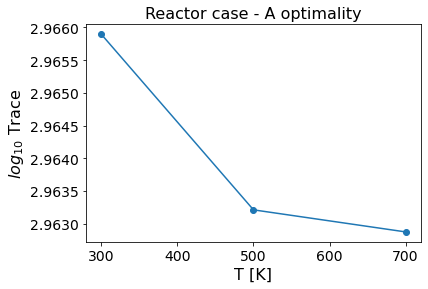

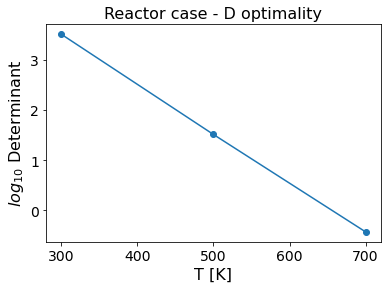

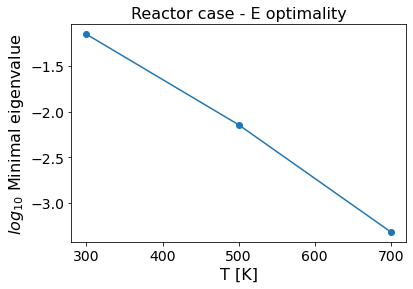

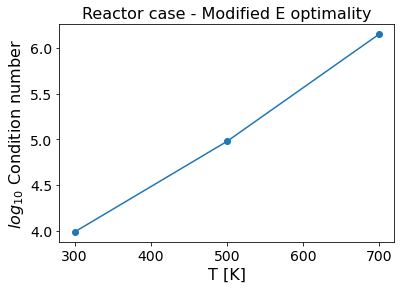

In [22]:
all_fim.extract_criteria()
#print(all_fim.store_all_results_dataframe)
## draw 1D sensitivity curve 

fixed = {"'CA0[0]'": 5.0}

all_fim.figure_drawing(fixed, ['T[0]'], 'Reactor case','T [K]','$C_{A0}$ [M]' )



## Heatmap

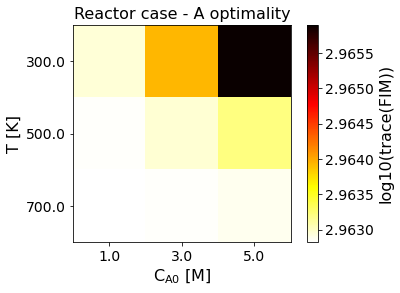

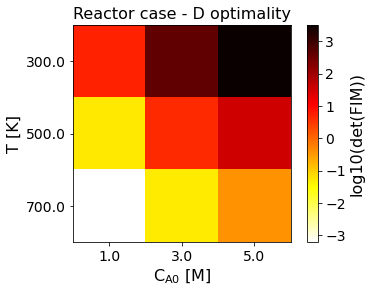

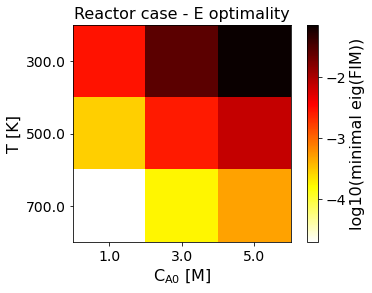

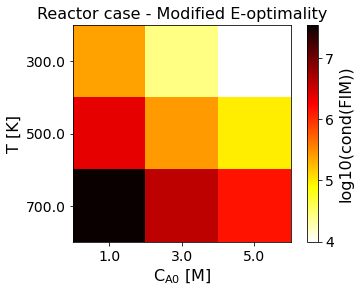

In [23]:
fixed = {}
all_fim.figure_drawing(fixed, ['CA0[0]','T[0]'], 'Reactor case','$C_{A0}$ [M]', 'T [K]' )

### Read Heatmaps

A heatmap shows the change of the objective function, a.k.a. the experimental information content, in the design region. Horizontal and vertical axes are two design variables, while the color of each grid shows the experimental information content. Taking the Fig. Reactor case - A optimality as example, A-optimality shows that the most informative region is around $C_{A0}=5.0$ M, $T=300.0$ K, while the least informative region is around $C_{A0}=1.0$ M, $T=700.0$ K.

## Grid search for 3 design variables

In [ ]:
# Define design ranges
design_ranges = [list(np.linspace(1,5,2)),  list(np.linspace(300,700,2)), [300,500]]

# Design variable names 
dv_apply_name = ['CA0[0]','T[0]',['T[0.125]','T[0.25]','T[0.375]','T[0.5]','T[0.625]','T[0.75]','T[0.875]','T[1]']]

## choose from 'sequential_finite', 'direct_kaug'
sensi_opt = calculation_mode.direct_kaug

In [ ]:
doe_object = DesignOfExperiments(parameter_dict, design_gen,
                                 measure_class, create_model,
                                prior_FIM=prior_pass, discretize_model=disc_for_measure)

all_fim = doe_object.run_grid_search(design_ranges, dv_apply_name, 
                                     mode=sensi_opt)

### Draw 1D sensitivity curve

In [ ]:
test = all_fim.extract_criteria()

In [ ]:
## draw 1D sensitivity curve 

fixed = {"'CA0[0]'": 1.0, "'T[0.125]'": 300}

all_fim.figure_drawing(fixed, ['T[0]'], 'Reactor case','T [K]','$C_{A0}$ [M]' )

### Draw 2D sensitivity curve

In [ ]:
fixed = {"'T[0.125]'": 300}

all_fim.figure_drawing(fixed, ['CA0[0]','T[0]'], 'Reactor case','$C_{A0}$ [M]', 'T [K]' )